In [ ]:
!git clone https://github.com/sky4689524/DefenseGAN-Pytorch.git

Cloning into 'DefenseGAN-Pytorch'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 4), reused 10 (delta 3), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [ ]:
%cd /content/DefenseGAN-Pytorch

/content/DefenseGAN-Pytorch


In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import os

from model import CNN
from torchsummary import summary
import copy

In [ ]:
batch_size = 32
total_epoch = 50

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

train_indices, val_indices = train_test_split(np.arange(len(trainset)), test_size=0.2)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=4,
    sampler=train_sampler
)

val_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=4,
    sampler=valid_sampler
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [ ]:
train_size = len(train_sampler)
val_size = len(valid_sampler)

In [ ]:
print('length trainset : {}, testset : {}'.format(len(trainset), len(testset)))

length trainset : 50000, testset : 10000


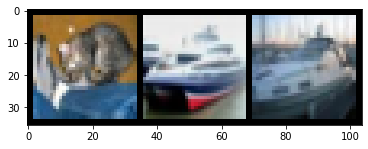

       cat       ship       ship


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:3]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(3)))

In [ ]:
# Send the model to GPU
model = CNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
summary(model, input_size = (3,32,32), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
         LeakyReLU-5           [-1, 64, 32, 32]               0
         AvgPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
        LeakyReLU-11          [-1, 128, 16, 16]               0
        AvgPool2d-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
      BatchNorm2d-14            [-1, 25

In [ ]:
model = model.to(device)

In [ ]:
model_folder = os.path.abspath('./checkpoints')
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model_path = os.path.join(model_folder, 'cifar10.pth')

In [ ]:
model.train()  # Set model to training mode

train_loss = []
train_acc = []
val_loss = []
val_acc = []

best_acc = 0.0

for epoch in range(total_epoch):

    model.train()  # Set model to training mode
    
    running_loss = 0.0
    running_corrects = 0.0
    epoch_size = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        _, preds = torch.max(outputs, 1)

        optimizer.step()

        # print statistics
        # statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        epoch_size += inputs.size(0)
        
    # Normalizing the loss by the total number of train batches
    
    running_loss /= epoch_size
    running_corrects =  running_corrects.double() / epoch_size
    
    train_loss.append(running_loss)
    train_acc.append(running_corrects)
    
    print('train Loss: {:.4f} Acc: {:.4f}'.format(running_loss, running_corrects))
    
    # evalute
    print('Finished epoch {}, starting evaluation'.format(epoch+1))

    model.eval()   # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0.0
    epoch_size = 0.0
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            
            epoch_size += inputs.size(0)
    
    running_loss /= epoch_size
    running_corrects =  running_corrects.double() / epoch_size
    
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(running_loss, running_corrects))
    
    val_loss.append(running_loss)
    val_acc.append(running_corrects)
    
    # deep copy the model
    if running_corrects > best_acc:
        print("saving best model val_acc : {:.4f}".format(running_corrects))
        best_acc = running_corrects
        
        model_copy = copy.deepcopy(model)
        model_copy = model_copy.cpu()
        
        model_state_dict = model_copy.state_dict()
        torch.save(model_state_dict, model_path)

        del model_copy

print('==> Finished Training ...')

train Loss: 0.0569 Acc: 0.3184
Finished epoch 1, starting evaluation
Validation Loss: 0.0491 Acc: 0.4289
saving best model val_acc : 0.4289
train Loss: 0.0430 Acc: 0.4924
Finished epoch 2, starting evaluation
Validation Loss: 0.0487 Acc: 0.4720
saving best model val_acc : 0.4720
train Loss: 0.0352 Acc: 0.5947
Finished epoch 3, starting evaluation
Validation Loss: 0.0403 Acc: 0.5443
saving best model val_acc : 0.5443
train Loss: 0.0298 Acc: 0.6573
Finished epoch 4, starting evaluation
Validation Loss: 0.0311 Acc: 0.6485
saving best model val_acc : 0.6485
train Loss: 0.0265 Acc: 0.6995
Finished epoch 5, starting evaluation
Validation Loss: 0.0307 Acc: 0.6610
saving best model val_acc : 0.6610
train Loss: 0.0241 Acc: 0.7267
Finished epoch 6, starting evaluation
Validation Loss: 0.0252 Acc: 0.7150
saving best model val_acc : 0.7150
train Loss: 0.0221 Acc: 0.7507
Finished epoch 7, starting evaluation
Validation Loss: 0.0207 Acc: 0.7658
saving best model val_acc : 0.7658
train Loss: 0.0204 A

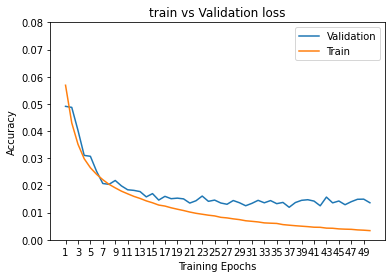

In [ ]:
hist = [h for h in val_loss]
hist2 = [h for h in train_loss]

plt.title("train vs Validation loss")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(val_loss)+1),hist,label="Validation")
plt.plot(range(1,len(train_loss)+1),hist2,label="Train")
plt.ylim((0,0.08))
plt.xticks(np.arange(1, len(train_loss)+1, 2))
plt.legend()
plt.show()